In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import warnings
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
warnings.filterwarnings("ignore")

In [1]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

In [4]:
# Assigning attribute name to dataset
dataset_train = pd.read_csv("KDDTrain+_2.csv", header=None, names = col_names)
dataset_test = pd.read_csv("KDDTest+_2.csv", header=None, names = col_names)

In [5]:
# colums that are categorical and not binary yet: protocol_type (column 2), service (column 3), flag (column 4).
# explore categorical features
print('Training set:')
for col_name in dataset_train.columns:
    if dataset_train[col_name].dtypes == 'object' :
        unique_cat = len(dataset_train[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

#see how distributed the feature service is, it is evenly distributed and therefore we need to make dummies for all.
print()
print('Distribution of categories in service:')
print(dataset_train['service'].value_counts().sort_values(ascending=False).head())


Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'label' has 23 categories

Distribution of categories in service:
service
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: count, dtype: int64


In [6]:
# Test set
print('Test set:')
for col_name in dataset_test.columns:
    if dataset_test[col_name].dtypes == 'object' :
        unique_cat = len(dataset_test[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))


Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 64 categories
Feature 'flag' has 11 categories
Feature 'label' has 38 categories


In [7]:
categorical_columns=['protocol_type', 'service', 'flag']
# insert code to get a list of categorical columns into a variable, categorical_columns
categorical_columns=['protocol_type', 'service', 'flag'] 
 # Get the categorical values into a 2D numpy array
dataset_train_categorical_values = dataset_train[categorical_columns]
dataset_test_categorical_values = dataset_test[categorical_columns]

In [8]:
# protocol type
unique_protocol=sorted(dataset_train.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
# service
unique_service=sorted(dataset_train.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
# flag
unique_flag=sorted(dataset_train.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2
print(dumcols)

#do same for test set
unique_service_test=sorted(dataset_test.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2

['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'serv

In [9]:
#Transform categorical features into numbers using LabelEncoder()
dataset_train_categorical_values_enc=dataset_train_categorical_values.apply(LabelEncoder().fit_transform)
print(dataset_train_categorical_values_enc.head())
# test set
dataset_test_categorical_values_enc=dataset_test_categorical_values.apply(LabelEncoder().fit_transform)

   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9


In [10]:
#One-Hot-Encoding¶
enc = OneHotEncoder()
dataset_train_categorical_values_encenc = enc.fit_transform(dataset_train_categorical_values_enc)
dataset_train_cat_data = pd.DataFrame(dataset_train_categorical_values_encenc.toarray(),columns=dumcols)
# test set
dataset_test_categorical_values_encenc = enc.fit_transform(dataset_test_categorical_values_enc)
dataset_test_cat_data = pd.DataFrame(dataset_test_categorical_values_encenc.toarray(),columns=testdumcols)

In [11]:
trainservice=dataset_train['service'].tolist()
testservice= dataset_test['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]
difference

['service_http_2784',
 'service_aol',
 'service_http_8001',
 'service_urh_i',
 'service_red_i',
 'service_harvest']

In [12]:
for col in difference:
    dataset_test_cat_data[col] = 0
dataset_test_cat_data.shape

(22544, 84)

In [13]:
#Join encoded categorical dataframe with the non-categorical dataframe
newdf=dataset_train.join(dataset_train_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)
# test data
newdf_test=dataset_test.join(dataset_test_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)
print(newdf.shape)
print(newdf_test.shape)

(125973, 123)
(22544, 123)


In [14]:
# take label column
labeldf=newdf['label']
labeldf_test=newdf_test['label']
# change the label column
newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
# put the new label column back
newdf['label'] = newlabeldf
newdf_test['label'] = newlabeldf_test


In [15]:
to_drop_DoS = [2,3,4]
to_drop_Probe = [1,3,4]
to_drop_R2L = [1,2,4]
to_drop_U2R = [1,2,3]
DoS_df=newdf[~newdf['label'].isin(to_drop_DoS)];
Probe_df=newdf[~newdf['label'].isin(to_drop_Probe)];
R2L_df=newdf[~newdf['label'].isin(to_drop_R2L)];
U2R_df=newdf[~newdf['label'].isin(to_drop_U2R)];

#test
DoS_df_test=newdf_test[~newdf_test['label'].isin(to_drop_DoS)];
Probe_df_test=newdf_test[~newdf_test['label'].isin(to_drop_Probe)];
R2L_df_test=newdf_test[~newdf_test['label'].isin(to_drop_R2L)];
U2R_df_test=newdf_test[~newdf_test['label'].isin(to_drop_U2R)];
print('Train:')
print('Dimensions of DoS:' ,DoS_df.shape)
print('Dimensions of Probe:' ,Probe_df.shape)
print('Dimensions of R2L:' ,R2L_df.shape)
print('Dimensions of U2R:' ,U2R_df.shape)
print('Test:')
print('Dimensions of DoS:' ,DoS_df_test.shape)
print('Dimensions of Probe:' ,Probe_df_test.shape)
print('Dimensions of R2L:' ,R2L_df_test.shape)
print('Dimensions of U2R:' ,U2R_df_test.shape)

Train:
Dimensions of DoS: (113270, 123)
Dimensions of Probe: (78999, 123)
Dimensions of R2L: (68338, 123)
Dimensions of U2R: (67395, 123)
Test:
Dimensions of DoS: (17171, 123)
Dimensions of Probe: (12132, 123)
Dimensions of R2L: (12596, 123)
Dimensions of U2R: (9778, 123)


In [16]:
# Split dataframes into X & Y
# assign X as a dataframe of feautures and Y as a series of outcome variables
X_DoS = DoS_df.drop(columns='label')
Y_DoS = DoS_df['label']
X_Probe = Probe_df.drop(columns='label')
Y_Probe = Probe_df['label']
X_R2L = R2L_df.drop(columns='label')
Y_R2L = R2L_df['label']
X_U2R = U2R_df.drop(columns='label')
Y_U2R = U2R_df['label']

# test set
X_DoS_test = DoS_df_test.drop(columns='label')
Y_DoS_test = DoS_df_test['label']
X_Probe_test = Probe_df_test.drop(columns='label')
Y_Probe_test = Probe_df_test['label']
X_R2L_test = R2L_df_test.drop(columns='label')
Y_R2L_test = R2L_df_test['label']
X_U2R_test = U2R_df_test.drop(columns='label')
Y_U2R_test = U2R_df_test['label']

In [17]:
colNames=list(X_DoS)
colNames_test=list(X_DoS_test)

In [18]:
scaler1 = preprocessing.StandardScaler().fit(X_DoS)
X_DoS=scaler1.transform(X_DoS) 
scaler2 = preprocessing.StandardScaler().fit(X_Probe)
X_Probe=scaler2.transform(X_Probe) 
scaler3 = preprocessing.StandardScaler().fit(X_R2L)
X_R2L=scaler3.transform(X_R2L) 
scaler4 = preprocessing.StandardScaler().fit(X_U2R)
X_U2R=scaler4.transform(X_U2R) 
# test data
scaler5 = preprocessing.StandardScaler().fit(X_DoS_test)
X_DoS_test=scaler5.transform(X_DoS_test) 
scaler6 = preprocessing.StandardScaler().fit(X_Probe_test)
X_Probe_test=scaler6.transform(X_Probe_test) 
scaler7 = preprocessing.StandardScaler().fit(X_R2L_test)
X_R2L_test=scaler7.transform(X_R2L_test) 
scaler8 = preprocessing.StandardScaler().fit(X_U2R_test)
X_U2R_test=scaler8.transform(X_U2R_test)


In [19]:
X_DoS.std(axis=0)
X_Probe.std(axis=0)
X_R2L.std(axis=0)
X_U2R.std(axis=0)

array([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1.])

# Random Forest

In [21]:
clf = RandomForestClassifier(n_jobs=2, random_state=0)

In [22]:
rfe = RFE(estimator=clf, n_features_to_select=13, step=1)
rfe.fit(X_DoS, Y_DoS.astype(int))
X_rfeDoS=rfe.transform(X_DoS)
X_rfeDoS_test=rfe.transform(X_DoS_test)
true=rfe.support_
rfecolindex_DoS=[i for i, x in enumerate(true) if x]
rfecolname_DoS=list(colNames[i] for i in rfecolindex_DoS)
print(rfecolname_DoS)

['src_bytes', 'dst_bytes', 'wrong_fragment', 'count', 'srv_count', 'serror_rate', 'same_srv_rate', 'diff_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'service_ecr_i', 'flag_S0', 'flag_SF']


In [23]:
rfe.fit(X_Probe, Y_Probe.astype(int))
X_rfeProbe=rfe.transform(X_Probe)
X_rfeProbe_test=rfe.transform(X_Probe_test)
true=rfe.support_
rfecolindex_Probe=[i for i, x in enumerate(true) if x]
rfecolname_Probe=list(colNames[i] for i in rfecolindex_Probe)
print(rfecolname_Probe)

['src_bytes', 'dst_bytes', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'Protocol_type_tcp', 'service_eco_i', 'service_private']


In [24]:
rfe.fit(X_R2L, Y_R2L.astype(int))
X_rfeR2L=rfe.transform(X_R2L)
X_rfeR2L_test=rfe.transform(X_R2L_test)
true=rfe.support_
rfecolindex_R2L=[i for i, x in enumerate(true) if x]
rfecolname_R2L=list(colNames[i] for i in rfecolindex_R2L)
print(rfecolname_R2L)

['duration', 'src_bytes', 'dst_bytes', 'hot', 'logged_in', 'is_guest_login', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'service_ftp_data']


In [25]:
rfe.fit(X_U2R, Y_U2R.astype(int))
X_rfeU2R=rfe.transform(X_U2R)
X_rfeU2R_test=rfe.transform(X_U2R_test)
true=rfe.support_
rfecolindex_U2R=[i for i, x in enumerate(true) if x]
rfecolname_U2R=list(colNames[i] for i in rfecolindex_U2R)
print(rfecolname_U2R)

['duration', 'src_bytes', 'dst_bytes', 'hot', 'num_compromised', 'root_shell', 'num_file_creations', 'count', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_same_src_port_rate', 'service_ftp_data']


In [26]:
print('Features selected for DoS:',rfecolname_DoS)
print()
print('Features selected for Probe:',rfecolname_Probe)
print()
print('Features selected for R2L:',rfecolname_R2L)
print()
print('Features selected for U2R:',rfecolname_U2R)

Features selected for DoS: ['src_bytes', 'dst_bytes', 'wrong_fragment', 'count', 'srv_count', 'serror_rate', 'same_srv_rate', 'diff_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'service_ecr_i', 'flag_S0', 'flag_SF']

Features selected for Probe: ['src_bytes', 'dst_bytes', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'Protocol_type_tcp', 'service_eco_i', 'service_private']

Features selected for R2L: ['duration', 'src_bytes', 'dst_bytes', 'hot', 'logged_in', 'is_guest_login', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'service_ftp_data']

Features selected for U2R: ['duration', 'src_bytes', 'dst_bytes', 'hot', 'num_compromised', 'root_shell', 'num_file_creations', 'count', 'dst_host_count', 'dst_host_s

In [27]:
print("Train:")
print(X_rfeDoS.shape)
print(X_rfeProbe.shape)
print(X_rfeR2L.shape)
print(X_rfeU2R.shape)
print("Test:")
print(X_rfeDoS_test.shape)
print(X_rfeProbe_test.shape)
print(X_rfeR2L_test.shape)
print(X_rfeU2R_test.shape)

Train:
(113270, 13)
(78999, 13)
(68338, 13)
(67395, 13)
Test:
(17171, 13)
(12132, 13)
(12596, 13)
(9778, 13)


In [28]:
# all features
clf_DoS=RandomForestClassifier(random_state=0)
clf_Probe=RandomForestClassifier(random_state=0)
clf_R2L=RandomForestClassifier(random_state=0)
clf_U2R=RandomForestClassifier(random_state=0)
clf_DoS.fit(X_DoS, Y_DoS.astype(int))
clf_Probe.fit(X_Probe, Y_Probe.astype(int))
clf_R2L.fit(X_R2L, Y_R2L.astype(int))
clf_U2R.fit(X_U2R, Y_U2R.astype(int))

RandomForestClassifier(random_state=0)

In [29]:
# selected features
clf_rfeDoS=RandomForestClassifier(random_state=0)
clf_rfeProbe=RandomForestClassifier(random_state=0)
clf_rfeR2L=RandomForestClassifier(random_state=0)
clf_rfeU2R=RandomForestClassifier(random_state=0)
clf_rfeDoS.fit(X_rfeDoS, Y_DoS.astype(int))
clf_rfeProbe.fit(X_rfeProbe, Y_Probe.astype(int))
clf_rfeR2L.fit(X_rfeR2L, Y_R2L.astype(int))
clf_rfeU2R.fit(X_rfeU2R, Y_U2R.astype(int))

RandomForestClassifier(random_state=0)

In [30]:
# Apply the classifier we trained to the test data (which it has never seen before)(All features)
Y_pred_Dos = clf_DoS.predict(X_DoS_test)
Y_pred_Probe = clf_Probe.predict(X_Probe_test)
Y_pred_R2L = clf_R2L.predict(X_R2L_test)
Y_pred_U2R = clf_U2R.predict(X_U2R_test)

In [31]:
# Apply the classifier we trained to the test data (which it has never seen before)(selected features)
Y_pred_rfeDos = clf_rfeDoS.predict(X_rfeDoS_test)
Y_pred_rfeProbe = clf_rfeProbe.predict(X_rfeProbe_test)
Y_pred_rfeR2L = clf_rfeR2L.predict(X_rfeR2L_test)
Y_pred_rfeU2R = clf_rfeU2R.predict(X_rfeU2R_test)

In [32]:
print("(All features)")
pd.crosstab(Y_DoS_test, Y_pred_Dos, rownames=['Actual attacks'], colnames=['Predicted attacks'])

(All features)


Predicted attacks,0,1
Actual attacks,,
0,9670,41
1,6654,806


In [33]:
print("(Selected features)")
pd.crosstab(Y_DoS_test, Y_pred_rfeDos, rownames=['Actual attacks'], colnames=['Predicted attacks'])

(Selected features)


Predicted attacks,0,1
Actual attacks,,
0,9659,52
1,7409,51


In [34]:
print("(All features)")
pd.crosstab(Y_Probe_test, Y_pred_Probe, rownames=['Actual attacks'], colnames=['Predicted attacks'])

(All features)


Predicted attacks,0,2
Actual attacks,,
0,9419,292
2,970,1451


In [35]:
print("(Selected features)")
pd.crosstab(Y_Probe_test, Y_pred_rfeProbe, rownames=['Actual attacks'], colnames=['Predicted attacks'])

(Selected features)


Predicted attacks,0,2
Actual attacks,,
0,9346,365
2,1229,1192


In [36]:
print("(All features)")
pd.crosstab(Y_R2L_test, Y_pred_R2L, rownames=['Actual attacks'], colnames=['Predicted attacks'])

(All features)


Predicted attacks,0
Actual attacks,
0,9711
3,2885


In [37]:
print("(Selected features)")
pd.crosstab(Y_R2L_test, Y_pred_rfeR2L, rownames=['Actual attacks'], colnames=['Predicted attacks'])

(Selected features)


Predicted attacks,0
Actual attacks,
0,9711
3,2885


In [38]:
print("(All features)")
pd.crosstab(Y_U2R_test, Y_pred_U2R, rownames=['Actual attacks'], colnames=['Predicted attacks'])

(All features)


Predicted attacks,0
Actual attacks,
0,9711
4,67


In [39]:
print("(Selected features)")
pd.crosstab(Y_U2R_test, Y_pred_rfeU2R, rownames=['Actual attacks'], colnames=['Predicted attacks'])

(Selected features)


Predicted attacks,0,4
Actual attacks,,
0,9710,1
4,60,7


In [40]:
print("(All Features)")
accuracy = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_DoS, X_DoS_test, Y_DoS_test, cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

(All Features)
Accuracy: 0.99819 (+/- 0.00198)
Precision: 0.99866 (+/- 0.00268)
Recall: 0.99718 (+/- 0.00369)
F-measure: 0.99792 (+/- 0.00228)


In [41]:
print("(Selected Features)")
accuracy = cross_val_score(clf_rfeDoS, X_rfeDoS_test, Y_DoS_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeDoS, X_rfeDoS_test, Y_DoS_test, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeDoS, X_rfeDoS_test, Y_DoS_test, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeDoS, X_rfeDoS_test, Y_DoS_test, cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

(Selected Features)
Accuracy: 0.99639 (+/- 0.00238)
Precision: 0.99532 (+/- 0.00362)
Recall: 0.99638 (+/- 0.00361)
F-measure: 0.99585 (+/- 0.00273)


In [42]:
print("(All Features)")
accuracy = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_Probe, X_Probe_test, Y_Probe_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

(All Features)
Accuracy: 0.99670 (+/- 0.00304)
Precision: 0.99577 (+/- 0.00456)
Recall: 0.99391 (+/- 0.00631)
F-measure: 0.99483 (+/- 0.00477)


In [43]:
print("(Selected Features)")
accuracy = cross_val_score(clf_rfeProbe, X_rfeProbe_test, Y_Probe_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeProbe, X_rfeProbe_test, Y_Probe_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeProbe, X_rfeProbe_test, Y_Probe_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeProbe, X_rfeProbe_test, Y_Probe_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

(Selected Features)
Accuracy: 0.99341 (+/- 0.00430)
Precision: 0.99092 (+/- 0.00696)
Recall: 0.98844 (+/- 0.01002)
F-measure: 0.98965 (+/- 0.00678)


In [44]:
print("(All Features)")
accuracy = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_R2L, X_R2L_test, Y_R2L_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

(All Features)
Accuracy: 0.98182 (+/- 0.00773)
Precision: 0.97544 (+/- 0.01042)
Recall: 0.97298 (+/- 0.01280)
F-measure: 0.97419 (+/- 0.01101)


In [45]:
print("(Selected Features)")
accuracy = cross_val_score(clf_rfeR2L, X_rfeR2L_test, Y_R2L_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeR2L, X_rfeR2L_test, Y_R2L_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeR2L, X_rfeR2L_test, Y_R2L_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeR2L, X_rfeR2L_test, Y_R2L_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

(Selected Features)
Accuracy: 0.97920 (+/- 0.00863)
Precision: 0.97342 (+/- 0.01483)
Recall: 0.96751 (+/- 0.01264)
F-measure: 0.97038 (+/- 0.01217)


In [46]:
print("(All Features)")
accuracy = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_U2R, X_U2R_test, Y_U2R_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

(All Features)
Accuracy: 0.99795 (+/- 0.00204)
Precision: 0.96125 (+/- 0.09646)
Recall: 0.88784 (+/- 0.11617)
F-measure: 0.91780 (+/- 0.08048)


In [47]:
print("(Selected Features)")
accuracy = cross_val_score(clf_rfeU2R, X_rfeU2R_test, Y_U2R_test, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeU2R, X_rfeU2R_test, Y_U2R_test, cv=10, scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeU2R, X_rfeU2R_test, Y_U2R_test, cv=10, scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeU2R, X_rfeU2R_test, Y_U2R_test, cv=10, scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

(Selected Features)
Accuracy: 0.99755 (+/- 0.00277)
Precision: 0.96647 (+/- 0.10008)
Recall: 0.85217 (+/- 0.18163)
F-measure: 0.89347 (+/- 0.12452)


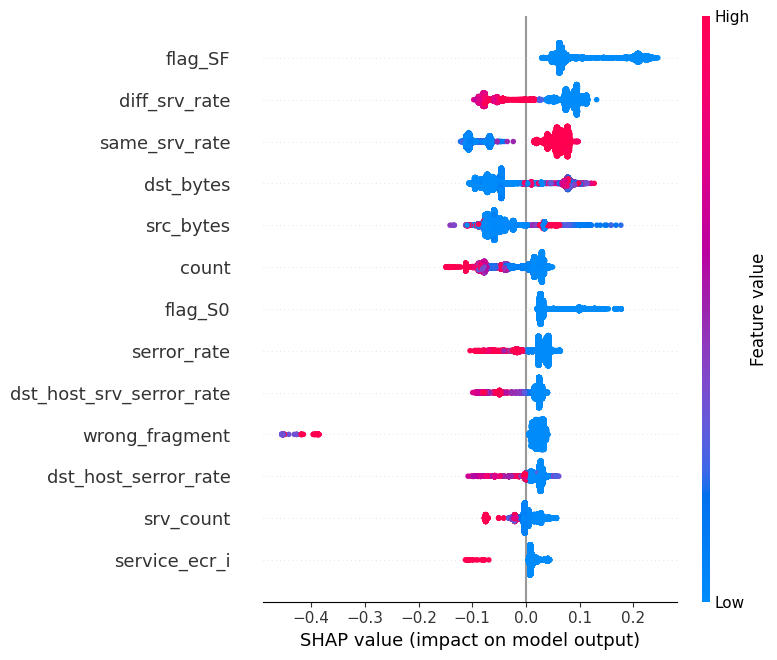

In [48]:
shap_values=shap.TreeExplainer(clf_rfeDoS).shap_values(X_rfeDoS_test)
shap_interaction_values=shap.TreeExplainer(clf_rfeDoS).shap_interaction_values(X_rfeDoS_test)
res = shap_values[:,:,0]
X_rfeDoS_test_df = pd.DataFrame(X_rfeDoS_test, columns=rfecolname_DoS)
shap.summary_plot(res, X_rfeDoS_test_df)

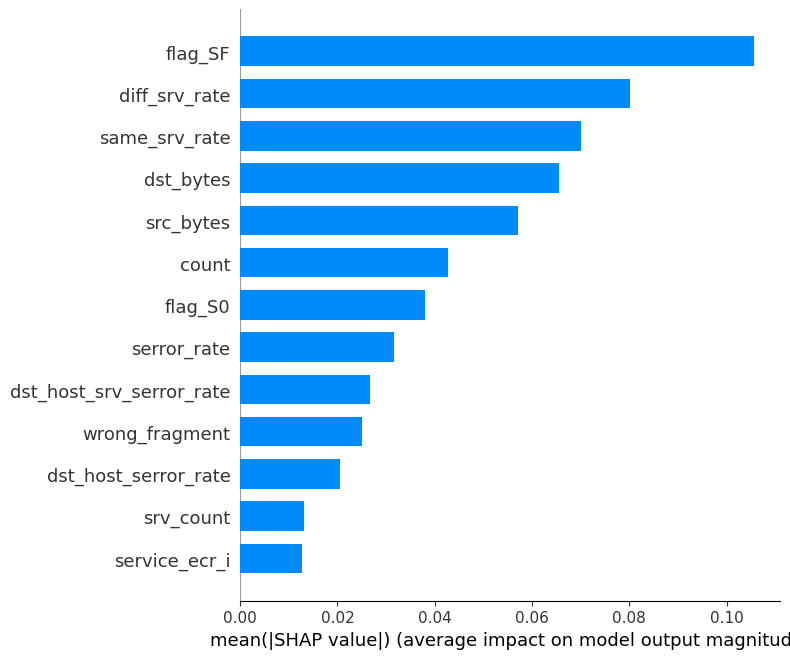

In [49]:
shap.summary_plot(res, X_rfeDoS_test_df , plot_type="bar")

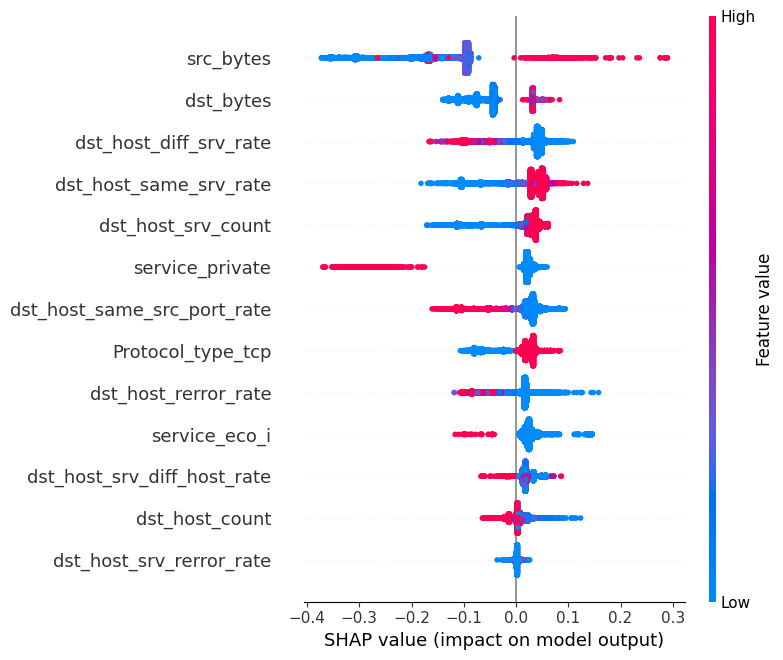

In [50]:
shap_values=shap.TreeExplainer(clf_rfeProbe).shap_values(X_rfeProbe_test)
shap_interaction_values=shap.TreeExplainer(clf_rfeProbe).shap_interaction_values(X_rfeProbe_test)
res = shap_values[:,:,0]
X_rfeProbe_test_df = pd.DataFrame(X_rfeProbe_test, columns=rfecolname_Probe)
shap.summary_plot(res, X_rfeProbe_test_df)

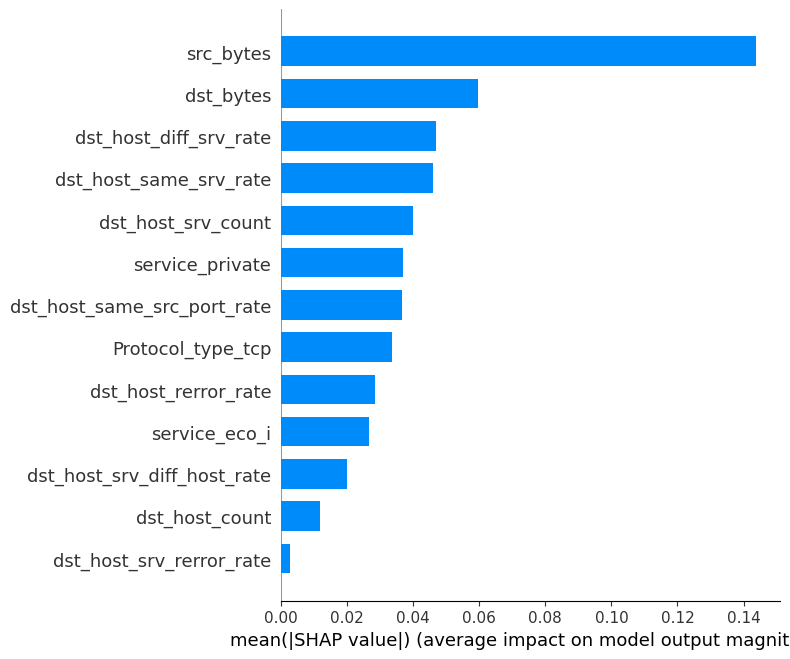

In [51]:
shap.summary_plot(res, X_rfeProbe_test_df,plot_type="bar")

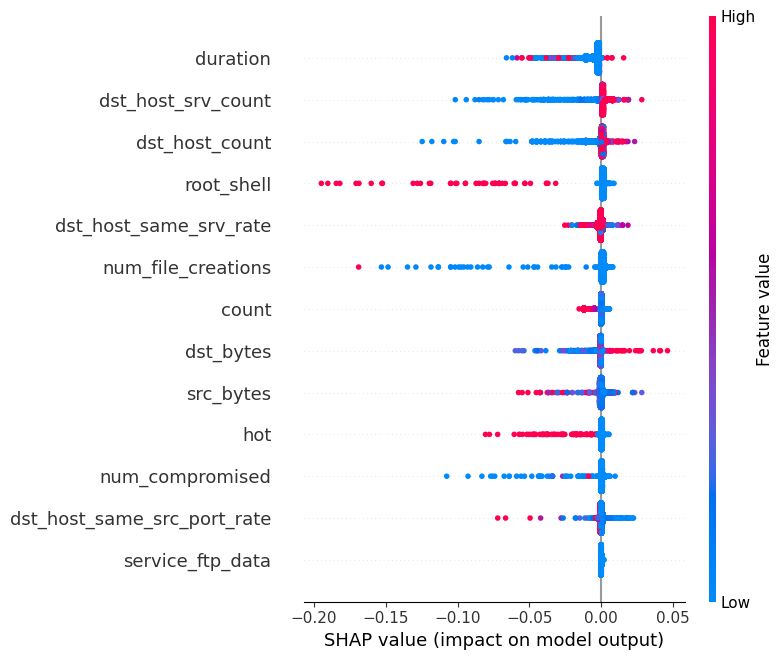

In [52]:
shap_values=shap.TreeExplainer(clf_rfeU2R).shap_values(X_rfeU2R_test)
shap_interaction_values=shap.TreeExplainer(clf_rfeU2R).shap_interaction_values(X_rfeU2R_test)
res = shap_values[:,:,0]
X_rfeU2R_test_df = pd.DataFrame(X_rfeU2R_test, columns=rfecolname_U2R)
shap.summary_plot(res, X_rfeU2R_test_df)

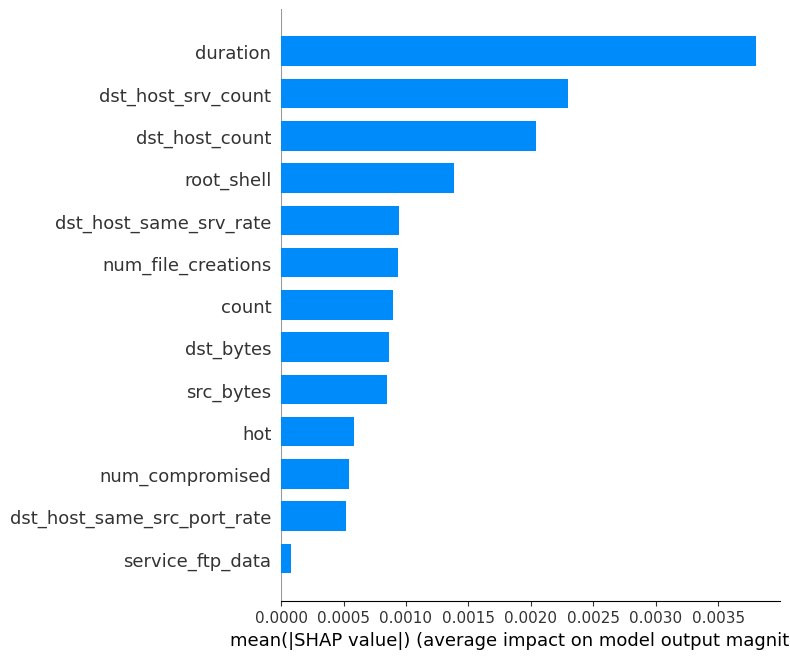

In [53]:
shap.summary_plot(res, X_rfeU2R_test_df, plot_type="bar")

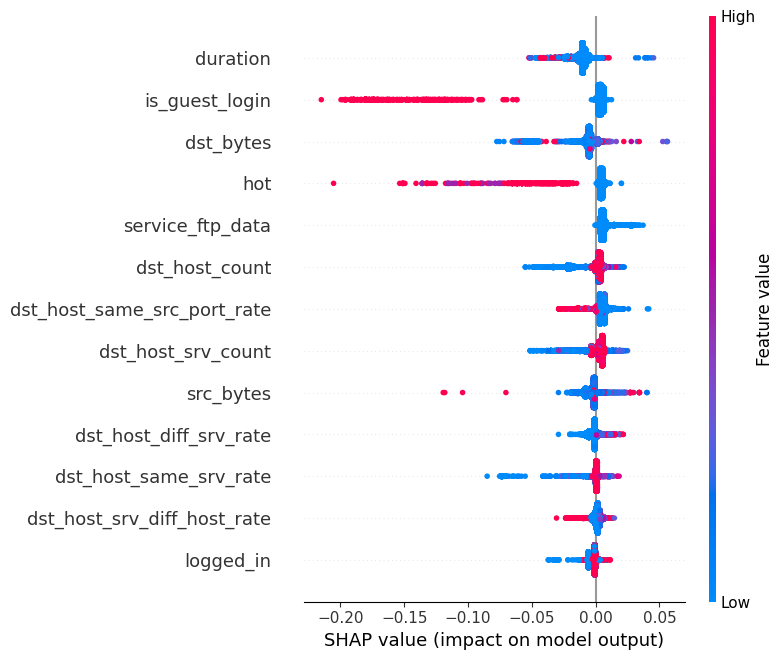

In [54]:
shap_values=shap.TreeExplainer(clf_rfeR2L).shap_values(X_rfeR2L_test)
shap_interaction_values=shap.TreeExplainer(clf_rfeR2L).shap_interaction_values(X_rfeR2L_test)
res = shap_values[:,:,0]
X_rfeR2L_test_df = pd.DataFrame(X_rfeR2L_test, columns=rfecolname_R2L)
shap.summary_plot(res, X_rfeR2L_test_df)

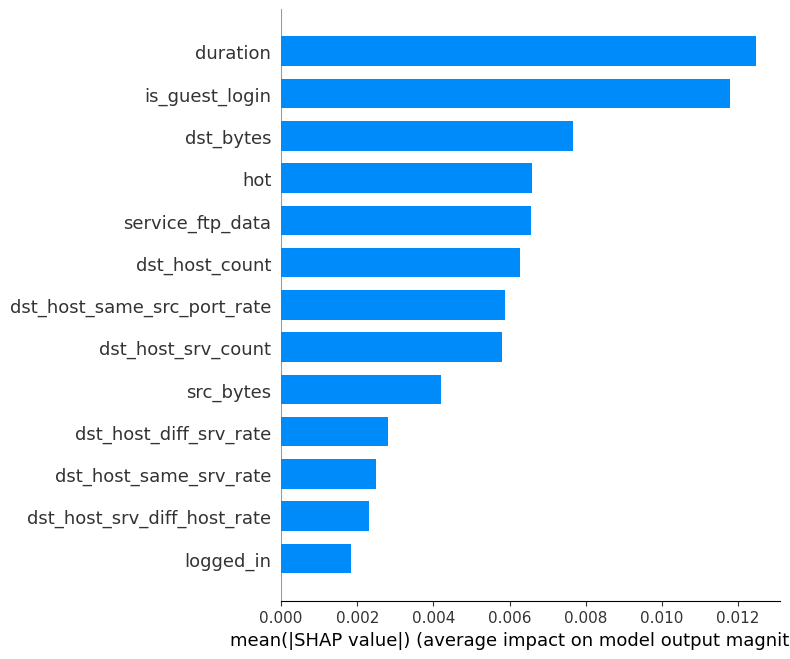

In [55]:
shap.summary_plot(res, X_rfeR2L_test_df, plot_type="bar")